In [1]:
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.stem import WordNetLemmatizer
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


### Preparing Stop Words

In [23]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['background', 'methods', 'introduction', 'conclusions', 'results', 
                   'purpose', 'materials', 'patients', 'purpose', 'also', 'use', 'high', 'month', 'week', 'disease'])

In [24]:
len(stop_words)

194

In [25]:
# Import Dataset
# Note: we need to add column that classifies articles into the target sets (see example above)
df = pd.read_csv('abstract.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Reference,Title,Abstract,Target,Target_Number
0,1. J Matern Fetal Neonatal Med. 2019 Oct;32(19...,Lung adenocarcinoma during pregnancy: clinical...,Lung cancer during pregnancy is a very rare di...,ALK,1
1,2. J Oncol Pharm Pract. 2019 Jul;25(5):1226-12...,A case report: Pharmacology and resistance pat...,BACKGROUND: Little exists currently in researc...,ALK,1
2,3. Clin Lung Cancer. 2019 May;20(3):e317-e328....,Phase 1 Study of Cabozantinib in Japanese Pati...,BACKGROUND: Cabozantinib inhibits tyrosine kin...,ALK,1
3,4. Clin Lung Cancer. 2019 May;20(3):215-221. d...,Efficacy and Safety of Lorlatinib in Korean No...,INTRODUCTION: Non-small-cell lung cancer (NSCL...,ALK,1
4,5. Curr Med Res Opin. 2019 Apr;35(4):569-576. ...,Comparative efficacy of brigatinib versus ceri...,"OBJECTIVE: Brigatinib, ceritinib, and alectini...",ALK,1


In [26]:
df.dropna(inplace=True)

In [27]:
df.isna().sum()

Reference        0
Title            0
Abstract         0
Target           0
Target_Number    0
dtype: int64

In [28]:
# Convert to list
data = df.Abstract.values.tolist()

print(data[:1])

['Lung cancer during pregnancy is a very rare disease with less than 70 cases published to date. Information about specific lung cancer as adenocarcinoma is even more limited. Genetic techniques can detect oncogene mutations which seem to be more frequent among cases of lung cancer in pregnant women and could determine both the treatment and prognosis. We present a recent case seen at our hospital and a literature review.']


In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

data_words = list(sent_to_words(data))

print(data_words[:1])

[['lung', 'cancer', 'during', 'pregnancy', 'is', 'very', 'rare', 'disease', 'with', 'less', 'than', 'cases', 'published', 'to', 'date', 'information', 'about', 'specific', 'lung', 'cancer', 'as', 'adenocarcinoma', 'is', 'even', 'more', 'limited', 'genetic', 'techniques', 'can', 'detect', 'oncogene', 'mutations', 'which', 'seem', 'to', 'be', 'more', 'frequent', 'among', 'cases', 'of', 'lung', 'cancer', 'in', 'pregnant', 'women', 'and', 'could', 'determine', 'both', 'the', 'treatment', 'and', 'prognosis', 'we', 'present', 'recent', 'case', 'seen', 'at', 'our', 'hospital', 'and', 'literature', 'review']]


### Creating Bigram and Trigram Models

Some examples in our example are: ‘death-ligand-1’, ‘PD-L1’, ‘non-small cell lung cancer’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more.

The two important arguments to Phrases are min_count and threshold.

The higher the values of these param, the harder it is for words to be combined to bigrams.

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[100]]])

['background', 'on', 'target', 'resistance', 'mechanisms', 'found', 'in', 'one', 'third', 'of', 'patients', 'receiving', 'anaplastic_lymphoma_kinase', 'alk', 'tyrosine_kinase', 'inhibitors', 'tkis', 'are', 'secondary', 'alk', 'mutations', 'in', 'alk', 'rearranged', 'non_small', 'cell', 'lung', 'cancer', 'nsclc', 'there', 'are', 'large', 'variations', 'in', 'the', 'resistant', 'mutations', 'unlike', 'the', 'epithelial_growth_factor', 'receptor', 'egfr', 'seen', 'with', 'the', 'use', 'of', 'egfr', 'tkis', 'liquid_biopsy', 'approaches', 'using', 'cell', 'free', 'dna_cfdna', 'are', 'used', 'for', 'screening', 'and', 'monitoring', 'of', 'mutations', 'in', 'nsclc', 'however', 'feasible', 'protocol', 'for', 'the', 'simultaneous', 'detection', 'of', 'multiple', 'secondary', 'alk', 'mutations', 'using', 'droplet_digital_pcr', 'ddpcr', 'has', 'not', 'been', 'developed', 'an', 'efficient', 'strategy', 'using', 'cfdna', 'in', 'cancer', 'diagnostics', 'the', 'development', 'of', 'more', 'accurate',

### Remove Stopwords, Make Bigrams and Lemmatize
Now that the bigrams model is ready, define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [31]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [249]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[100])

['target', 'resistance', 'mechanism', 'find', 'third', 'receive', 'anaplastic_lymphoma', 'kinase', 'alk', 'tyrosine_kinase', 'inhibitor', 'tki', 'secondary', 'alk', 'mutation', 'alk', 'rearranged', 'non_small', 'cell', 'lung', 'cancer', 'nsclc', 'large', 'variation', 'resistant', 'mutation', 'epithelial', 'growth_factor', 'receptor', 'egfr', 'see', 'egfr', 'tkis', 'liquid_biopsy', 'approach', 'use', 'cell', 'free', 'use', 'screen', 'monitoring', 'mutation', 'nsclc', 'however', 'feasible', 'protocol', 'simultaneous', 'detection', 'multiple', 'secondary', 'alk', 'mutation', 'use', 'droplet_digital', 'pcr', 'ddpcr', 'develop', 'efficient', 'strategy', 'use', 'cfdna', 'cancer', 'diagnostic', 'development', 'accurate', 'cost_effective', 'tool', 'identify', 'informative', 'multiple', 'secondary', 'alk', 'mutation', 'clinically', 'require', 'establish', 'feasible', 'assay', 'monitor', 'alk', 'tki', 'resistance', 'mutation', 'first', 'evaluated', 'feasibility', 'ddpcr', 'base', 'screen', 'cfdn

In [251]:
print(data_lemmatized[:100])

[['lung', 'cancer', 'pregnancy', 'rare', 'less', 'case', 'publish', 'date', 'information', 'specific', 'lung', 'cancer', 'adenocarcinoma', 'even', 'limited', 'genetic', 'technique', 'detect', 'oncogene', 'mutation', 'seem', 'frequent', 'case', 'lung', 'cancer', 'pregnant', 'woman', 'could', 'determine', 'treatment', 'prognosis', 'present', 'recent', 'case', 'see', 'hospital', 'literature', 'review'], ['little', 'exist', 'currently', 'research', 'mechanism', 'resistance', 'alk', 'inhibitor', 'inflammatory_myofibroblastic', 'sarcoma', 'know', 'however', 'alk', 'gene', 'rearrangement', 'common', 'inflammatory_myofibroblastic', 'tumor', 'similar', 'cell', 'lung', 'cancer', 'roughly', 'inflammatory_myofibroblastic', 'tumor', 'gene', 'rearrangement', 'find', 'occur', 'chromosome', 'band', 'cell', 'lung', 'cancer', 'show', 'third', 'progress', 'first', 'generation', 'alk', 'inhibitor', 'crizotinib', 'develop', 'mutation', 'alk', 'kinase', 'domain', 'remain', 'tend', 'develop', 'amplification'

'inflammatory_myofibroblastic'
'anaplastic_lymphoma'
'confidence_interval'
'locally_advance'
'tyrosine_kinase'
'chromosomal_rearrangement'
'aggressive_behavior'
'chromosomal_rearrangement'
'precision_medicine'

### Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus is a mapping of (word_id, word_frequency). This is used as the input by the LDA model. To see the word associated with an id, use id2word.

In [34]:
id2word[0]

'adenocarcinoma'

In [35]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adenocarcinoma', 1),
  ('cancer', 3),
  ('case', 3),
  ('could', 1),
  ('date', 1),
  ('detect', 1),
  ('determine', 1),
  ('even', 1),
  ('frequent', 1),
  ('genetic', 1),
  ('hospital', 1),
  ('information', 1),
  ('less', 1),
  ('limited', 1),
  ('literature', 1),
  ('lung', 3),
  ('mutation', 1),
  ('oncogene', 1),
  ('pregnancy', 1),
  ('pregnant', 1),
  ('present', 1),
  ('prognosis', 1),
  ('publish', 1),
  ('rare', 1),
  ('recent', 1),
  ('review', 1),
  ('see', 1),
  ('seem', 1),
  ('specific', 1),
  ('technique', 1),
  ('treatment', 1),
  ('woman', 1)]]

### Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.


In [274]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True
                                           )

In [275]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.062*"cell" + 0.015*"immune" + 0.012*"treatment" + 0.012*"target" + '
  '0.011*"cd" + 0.011*"role" + 0.011*"response" + 0.010*"therapy" + '
  '0.010*"tumor" + 0.010*"cancer"'),
 (1,
  '0.065*"psoriasis" + 0.032*"skin" + 0.024*"cytokine" + 0.021*"cell" + '
  '0.018*"inflammatory" + 0.013*"mouse" + 0.013*"inflammation" + '
  '0.010*"induce" + 0.009*"il" + 0.009*"psoriatic"'),
 (2,
  '0.035*"treatment" + 0.021*"response" + 0.021*"nivolumab" + '
  '0.015*"inhibitor" + 0.013*"nsclc" + 0.013*"therapy" + 0.012*"trial" + '
  '0.012*"treat" + 0.012*"chemotherapy" + 0.011*"clinical"'),
 (3,
  '0.095*"pd" + 0.044*"lung" + 0.030*"cancer" + 0.025*"nsclc" + 0.011*"tumor" '
  '+ 0.010*"programmed_death" + 0.010*"mutation" + 0.010*"egfr" + '
  '0.009*"clinical" + 0.009*"biomarker"'),
 (4,
  '0.054*"expression" + 0.046*"cell" + 0.032*"cd" + 0.018*"level" + '
  '0.017*"gene" + 0.014*"study" + 0.013*"tumor" + 0.012*"use" + 0.011*"ad" + '
  '0.011*"mrna"')]


**Analysis:** Each line articulates the top keywords that contribute to the article, with the weight of that topic. The weight reflects how important the keyword is in the classification of the abstract.  

In [276]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.42596553307524

Coherence Score:  0.5387554253316068


### Visualize the topics-keywords
With the LDA model, we now examine the produced topics and associated keywords. We use pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [277]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.058716  0.057787       1        1  34.446754
3      0.179410 -0.073767       2        1  28.740692
2      0.118114 -0.165588       3        1  14.654076
4     -0.002926  0.266989       4        1  12.568979
1     -0.353315 -0.085422       5        1   9.589498, topic_info=      Category          Freq                  Term         Total  loglift  \
420    Default  19837.000000                    pd  19837.000000  30.0000   
54     Default  21624.000000                  cell  21624.000000  29.0000   
14352  Default   4519.000000             psoriasis   4519.000000  28.0000   
548    Default   5628.000000            expression   5628.000000  27.0000   
15     Default   9541.000000                  lung   9541.000000  26.0000   
1600   Default   5830.000000                    cd   5830.000000  25.0000   
30     Default   7832.000000             treatment   7832.000000  24.0000   
215    Default   6571.000000                 nsclc   6571.000000  23.0000   
3770   Default   2261.000000                  skin   2261.000000  22.0000   
1585   Default   2205.000000             nivolumab   2205.000000  21.0000   
1670   Default   1856.000000              cytokine   1856.000000  20.0000   
1      Default   9177.000000                cancer   9177.000000  19.0000   
141    Default   5591.000000              response   5591.000000  18.0000   
762    Default   4101.000000                immune   4101.000000  17.0000   
89     Default   3081.000000                  gene   3081.000000  16.0000   
316    Default   2267.000000                 level   2267.000000  15.0000   
555    Default   1272.000000          inflammatory   1272.000000  14.0000   
428    Default   2118.000000      programmed_death   2118.000000  13.0000   
16     Default   2086.000000              mutation   2086.000000  12.0000   
285    Default   2257.000000                 trial   2257.000000  11.0000   
101    Default   4370.000000             inhibitor   4370.000000  10.0000   
191    Default   2032.000000                  egfr   2032.000000   9.0000   
168    Default   5964.000000                 tumor   5964.000000   8.0000   
740    Default   1450.000000          chemotherapy   1450.000000   7.0000   
162    Default   4953.000000               therapy   4953.000000   6.0000   
379    Default   1784.000000             biomarker   1784.000000   5.0000   
1965   Default    981.000000                 mouse    981.000000   4.0000   
366    Default   3460.000000                  role   3460.000000   3.0000   
280    Default   3929.000000                target   3929.000000   2.0000   
3214   Default   1031.000000                    ad   1031.000000   1.0000   
...        ...           ...                   ...           ...      ...   
10335   Topic5    225.219238  rheumatoid_arthritis    226.565002   2.3385   
1257    Topic5    201.457993             infection    202.771164   2.3380   
5507    Topic5    220.507294             epidermal    221.967361   2.3379   
16072   Topic5    253.745743           ustekinumab    255.524338   2.3375   
11115   Topic5    184.722046                   ccr    186.042221   2.3374   
3006    Topic5    176.983200            pathogenic    178.302277   2.3371   
4063    Topic5    169.316025                 joint    170.632858   2.3368   
11782   Topic5    156.889725       necrosis_factor    158.223145   2.3360   
13887   Topic5    153.336182                   ccl    154.658081   2.3359   
3799    Topic5    149.936356            neutrophil    151.279205   2.3356   
12034   Topic5    143.774017       proinflammatory    145.102020   2.3353   
16077   Topic5    170.345123     atopic_dermatitis    172.206070   2.3336   
3181    Topic5    280.154419              disorder    288.132843   2.3164   
1670    Topic5   1691.711792              cytokine   1856.291260   2.2517   
1965    Topic5    913.128723         

In [275]:
#save chart to html file 
#pyLDAvis.save_html(vis, 'lda4topics_v2.html')

**Analysis:**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.  A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

If we move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.  We will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

### Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. 

In [39]:
#import os 

#os.environ['MALLET_HOME'] = '/Users/chrisriggio/Documents/program_stuff/Final_Project/mallet-2.0.8'
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = '/Users/chrisriggio/Documents/program_stuff/Final_Project/mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [44]:
optimal_model = lda_model

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.062*"cell" + 0.015*"immune" + 0.012*"treatment" + 0.012*"target" + '
  '0.011*"cd" + 0.011*"role" + 0.011*"response" + 0.010*"therapy" + '
  '0.010*"tumor" + 0.010*"cancer" + 0.009*"clinical" + 0.009*"receptor" + '
  '0.008*"pathway" + 0.008*"therapeutic" + 0.007*"development" + '
  '0.006*"include" + 0.006*"new" + 0.005*"mechanism" + 0.005*"immunotherapy" + '
  '0.005*"activation"'),
 (1,
  '0.065*"psoriasis" + 0.032*"skin" + 0.024*"cytokine" + 0.021*"cell" + '
  '0.018*"inflammatory" + 0.013*"mouse" + 0.013*"inflammation" + '
  '0.010*"induce" + 0.009*"il" + 0.009*"psoriatic" + 0.009*"disease" + '
  '0.008*"increase" + 0.008*"produce" + 0.008*"pathogenesis" + 0.008*"tnf" + '
  '0.008*"psa" + 0.007*"production" + 0.007*"lesion" + 0.007*"keratinocyte" + '
  '0.007*"human"'),
 (2,
  '0.035*"treatment" + 0.021*"response" + 0.021*"nivolumab" + '
  '0.015*"inhibitor" + 0.013*"nsclc" + 0.013*"therapy" + 0.012*"trial" + '
  '0.012*"treat" + 0.012*"chemotherapy" + 0.011*"clinical" +

### Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.



In [45]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

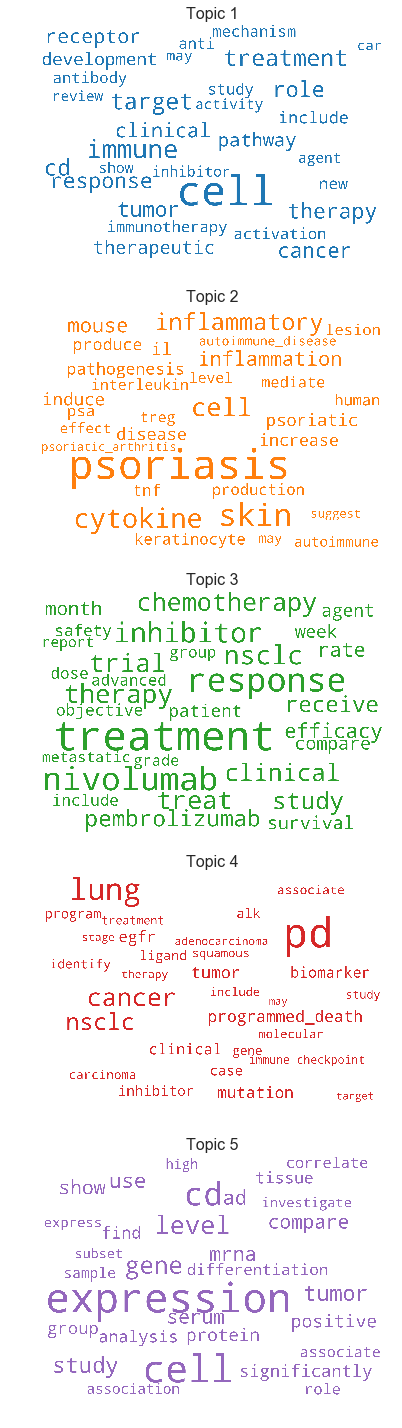

In [278]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, 
                               num_words=30)

fig, axes = plt.subplots(5, 1, figsize=(10,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

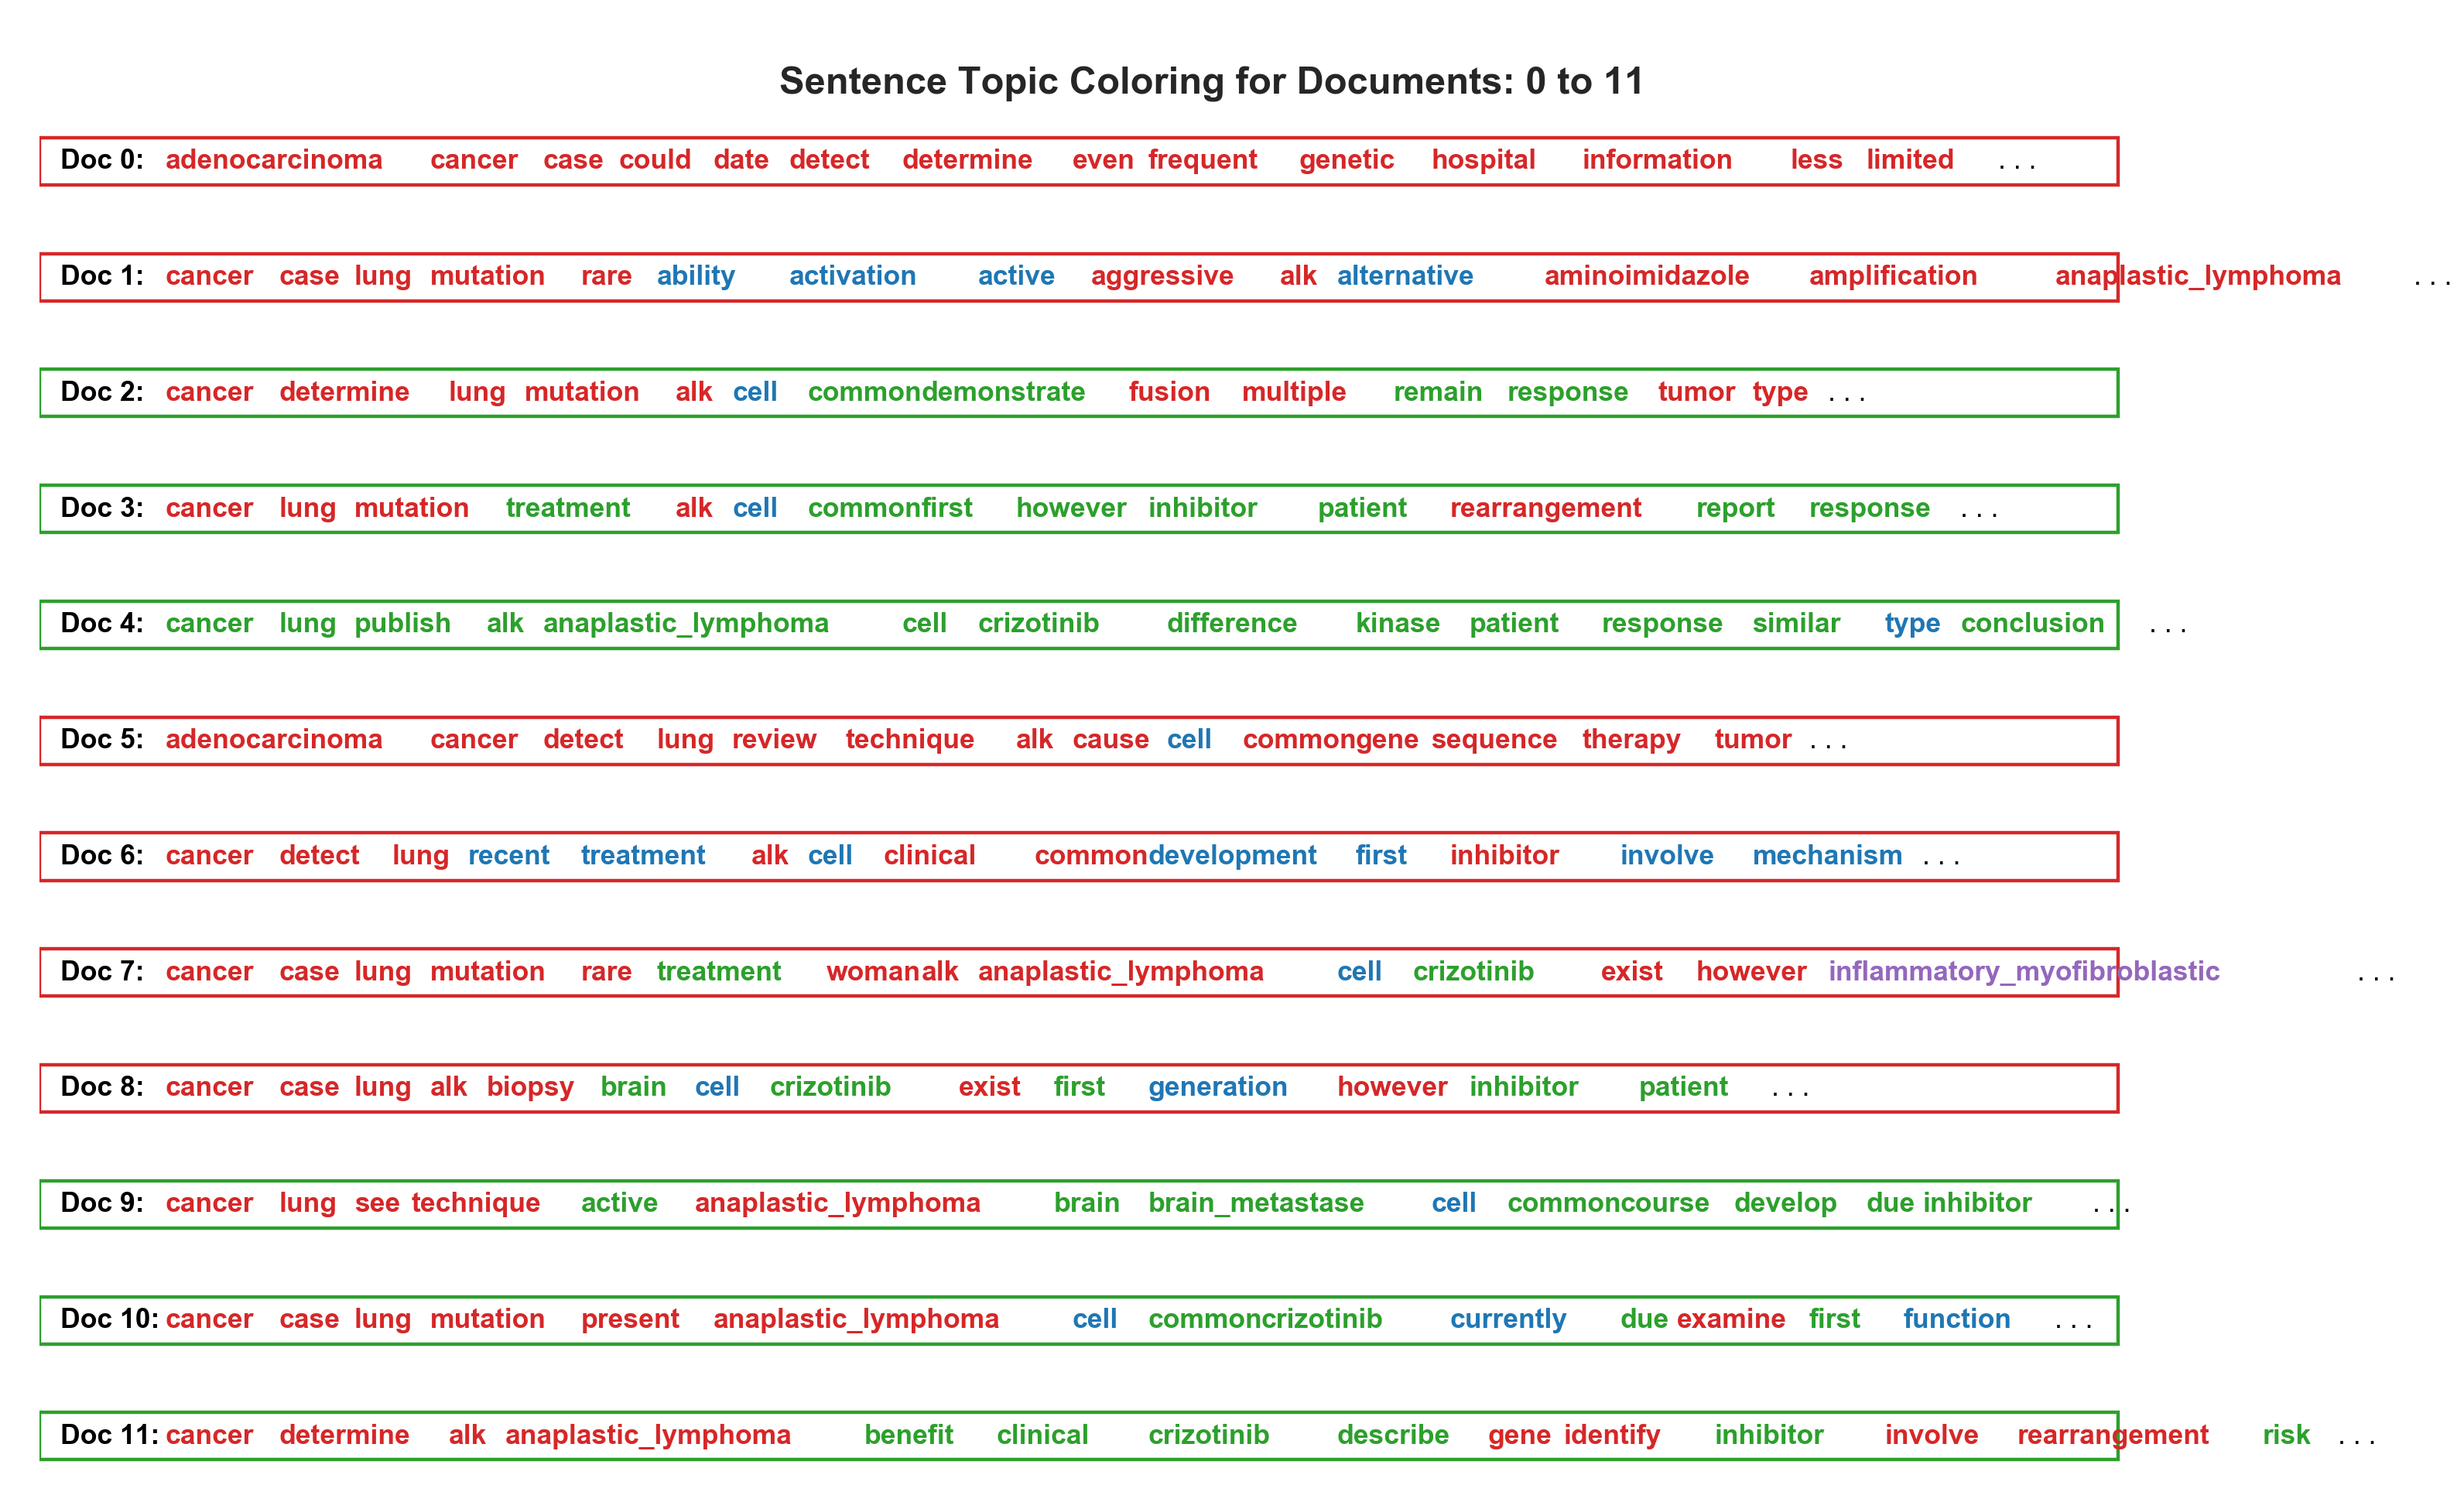

In [279]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

**What are the most discussed topics in the documents? Let’s compute the total number of documents attributed to each topic.**

In [260]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

**Let’s make two plots:**

* The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
* The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

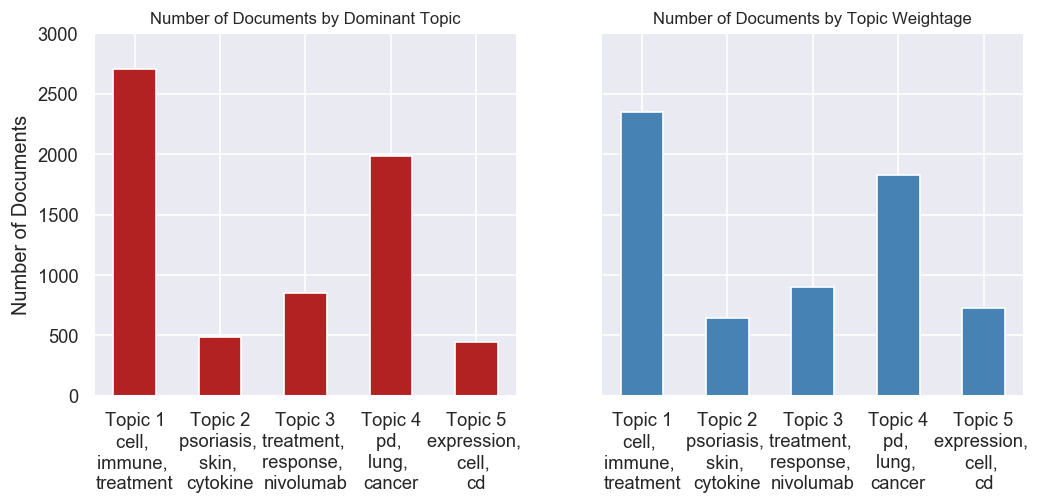

In [261]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 3000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart 

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [265]:
from bokeh.models import HoverTool

In [273]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])


plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot);

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6296 samples in 0.003s...
[t-SNE] Computed neighbors for 6296 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6296
[t-SNE] Computed conditional probabilities for sample 2000 / 6296
[t-SNE] Computed conditional probabilities for sample 3000 / 6296
[t-SNE] Computed conditional probabilities for sample 4000 / 6296
[t-SNE] Computed conditional probabilities for sample 5000 / 6296
[t-SNE] Computed conditional probabilities for sample 6000 / 6296
[t-SNE] Computed conditional probabilities for sample 6296 / 6296
[t-SNE] Mean sigma: 0.032963
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.147377
[t-SNE] KL divergence after 1000 iterations: 0.974641


Loading BokehJS ...

### Grid Search

In [76]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


In [99]:
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
#     return texts_out

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # Run in terminal: python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])

# # Do lemmatization keeping only Noun, Adj, Verb, Adverb
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:2])

In [101]:
# vectorizer = CountVectorizer(analyzer='word',       
#                              min_df=10,                        # minimum reqd occurences of a word 
#                              stop_words='english',             # remove stop words
#                              lowercase=True,                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}'  # num chars > 3
#                              # max_features=50000,             # max number of uniq words
#                             )
# data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [102]:
#this cell takes forever to run 

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(n_jobs=-1)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)


# Do the Grid Search
model.fit(data_vectorized)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=-1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                     

In [103]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -1704774.8022422967
Model Perplexity:  613.2554980343524


### Predictions

In [111]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [213]:
categories = list(df.Target.unique())
categories

['ALK', 'CAR-T', 'PD-L1', 'Th17']

In [214]:
X = df.Abstract
y = df.Target_Number

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [215]:
X_train[0]

'Lung cancer during pregnancy is a very rare disease with less than 70 cases published to date. Information about specific lung cancer as adenocarcinoma is even more limited. Genetic techniques can detect oncogene mutations which seem to be more frequent among cases of lung cancer in pregnant women and could determine both the treatment and prognosis. We present a recent case seen at our hospital and a literature review.'

In [216]:
# v = TfidfVectorizer(decode_error='replace', encoding='utf-8')
# target = v.fit_transform(df['Target'].values.astype('U'))  ## Even astype(str) would work


In [217]:
# train = list(df.Abstract)
# test = list(df.Title)
# # target = list(df.Target)

In [218]:
train[5]

'Non-small cell lung cancer can exhibit driver oncogenes, including epidermal growth factor receptor (EGFR) and anaplastic lymphoma kinase (ALK), that are possible targets for therapy. The prevalence of these rearranged driver oncogenes is influenced by race, smoking habits, and gender. Most data come from Caucasian  and Asian populations. To our knowledge, there is no literature available about the prevalence of driver oncogenes in Sub-Saharan Africa, where the tobacco epidemic is still in the early stage. In this small case series, 6 patients of Sub-Saharan African ethnicity with stage IV lung adenocarcinoma are described. EGFR mutation was present in 3/6 patients and ALK rearrangement in 1/6 patients.  This incidence seems high but interestingly, all patients were non-smokers or light smokers. In this series, the high prevalence of driver oncogene was probably related to low smoking habits and these initial data in Sub-Saharan Africans suggest high prevalence of driver mutations for

In [219]:
words = train[5].split()
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table).lower() for w in words]
print(" ".join(stripped[:100]))

nonsmall cell lung cancer can exhibit driver oncogenes including epidermal growth factor receptor egfr and anaplastic lymphoma kinase alk that are possible targets for therapy the prevalence of these rearranged driver oncogenes is influenced by race smoking habits and gender most data come from caucasian and asian populations to our knowledge there is no literature available about the prevalence of driver oncogenes in subsaharan africa where the tobacco epidemic is still in the early stage in this small case series 6 patients of subsaharan african ethnicity with stage iv lung adenocarcinoma are described egfr mutation was present in 36 patients


In [220]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [221]:
pipe = Pipeline(steps=[('count', CountVectorizer()), ('nb', MultinomialNB())])


In [222]:
pipe.fit(X_train, y_train)
labels = pipe.predict(X_test)

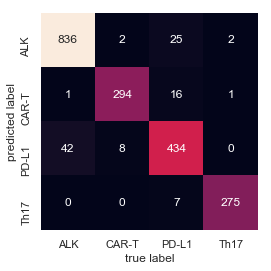

In [223]:
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [224]:
accuracy_score(y_test, labels)

0.9464745239320638

In [225]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.97      0.95      0.96       879
           2       0.94      0.97      0.95       304
           3       0.90      0.90      0.90       482
           4       0.98      0.99      0.98       278

    accuracy                           0.95      1943
   macro avg       0.95      0.95      0.95      1943
weighted avg       0.95      0.95      0.95      1943



In [226]:
tfidf_pipe = Pipeline(steps=[('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [227]:
tfidf_pipe.fit(X_train, y_train)
tfidf_labels = tfidf_pipe.predict(X_test)

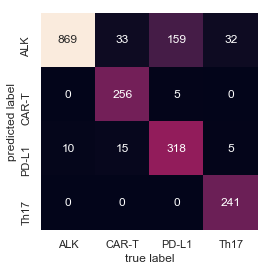

In [228]:
mat = confusion_matrix(y_test, tfidf_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [229]:
print("F1 Score:", f1_score(y_test, tfidf_labels, average='weighted'))
print("Accuracy:", accuracy_score(y_test, tfidf_labels))

F1 Score: 0.8634589896934977
Accuracy: 0.8667009778692744


In [230]:
param_grid = {
    'count__max_df': [0.5, 0.6,0.7,0.8],
    'count__min_df': [2,3,4,5],
    'count__stop_words': ['english', None]
}


In [231]:
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.6min finished


Best parameter (CV score=0.951):
{'count__max_df': 0.7, 'count__min_df': 3, 'count__stop_words': 'english'}


In [232]:
labels = search.best_estimator_.predict(X_test)

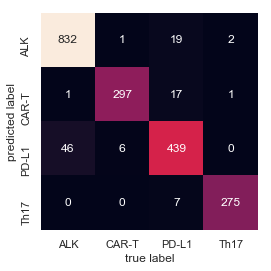

In [233]:
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [234]:
print("F1 Score:", f1_score(y_test, labels, average='weighted'))
print("Accuracy:", accuracy_score(y_test, labels))

F1 Score: 0.9486510541022118
Accuracy: 0.9485331960885229


In [211]:
# def predict_category(s, train=X, model=search.best_estimator_):
#     pred = model.predict([s])
#     return df.Target[pred[0]]

In [238]:
#predict_category('This is PDL1')

### Using Test Data 

In [243]:
test_df = pd.read_csv("abstract_test.csv")
test_df.drop(['Unnamed: 0'], axis=1, inplace=True)
test_df.head()

,Reference,Title,Abstract,Target,Target_Number
0,1. J Matern Fetal Neonatal Med. 2019 Oct;32(19...,Lung adenocarcinoma during pregnancy: clinical...,Lung cancer during pregnancy is a very rare di...,ALK,1
1,3. Ann Thorac Surg. 2019 Jul;108(1):219-226. d...,Next-Generation Sequencing for Genotyping of E...,BACKGROUND: Endobronchial ultrasound-guided tr...,ALK,1
2,4. Cancer Chemother Pharmacol. 2019 Jul;84(1):...,Clinical implications of an analysis of pharma...,PURPOSE: Dexamethasone is a systemic corticost...,ALK,1
3,5. Eur J Cancer. 2019 Jul;116:86-97. doi: 10.1...,Clinical outcomes of non-small-cell lung cance...,INTRODUCTION: Patients with stage IV non-small...,ALK,1
4,6. Histopathology. 2019 Jul;75(1):20-28. doi: ...,Anaplastic lymphoma kinase expression in small...,AIMS: Anaplastic lymphoma kinase (ALK) immunoh...,ALK,1


In [247]:
df.Abstract[0]

'Lung cancer during pregnancy is a very rare disease with less than 70 cases published to date. Information about specific lung cancer as adenocarcinoma is even more limited. Genetic techniques can detect oncogene mutations which seem to be more frequent among cases of lung cancer in pregnant women and could determine both the treatment and prognosis. We present a recent case seen at our hospital and a literature review.'

In [248]:
test_df.Abstract[0]

'Lung cancer during pregnancy is a very rare disease with less than 70 cases published to date. Information about specific lung cancer as adenocarcinoma is even more limited. Genetic techniques can detect oncogene mutations which seem to be more frequent among cases of lung cancer in pregnant women and could determine both the treatment and prognosis. We present a recent case seen at our hospital and a literature review.   "2. Int J Cancer. 2019 Aug 1;145(3):649-661. doi: 10.1002/ijc.32133. Epub 2019 Feb 19."'